### Notebook for the following paper:

http://iopscience.iop.org/article/10.3847/1538-3881/aa9ab8/meta

* Pavlos, Karim, and Nicolás Castro

###### General Overview:
The paper is on treating features as distributions.  It uses Gaussian Processes (GP) to treat the time series like a distribution, making use of both the measurement error given in the data, $\epsilon$, and the error associated with gaps in the time series.  The paper also covers sampling from the distributions and training a random forest based on the samples (randomness in the data from the sampling, not the feature selection).

In [23]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

%matplotlib inline

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,class
0,0.438,0.498,3.625,3.645,5.0,2.918,5.0,2.351,2.332,2.643,...,0.593,0.502,0.493,0.504,0.445,0.431,0.444,0.440,0.429,Slight-Right-Turn
1,0.438,0.498,3.625,3.648,5.0,2.918,5.0,2.637,2.332,2.649,...,0.592,0.502,0.493,0.504,0.449,0.431,0.444,0.443,0.429,Slight-Right-Turn
2,0.438,0.498,3.625,3.629,5.0,2.918,5.0,2.637,2.334,2.643,...,0.593,0.502,0.493,0.504,0.449,0.431,0.444,0.446,0.429,Slight-Right-Turn


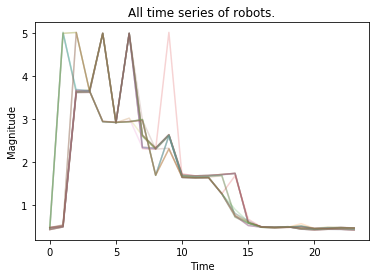

In [19]:
# Read data
fnames = [f'feat_{i}' for i in range(24)]+['class']
robo = pd.read_csv('paper_data/sensor_readings.csv',names=fnames)

# Plot data
for i in range(24):
    plt.plot(list(range(24)),robo.iloc[i,:-1],alpha=0.2)
plt.title('All time series of robots.')
plt.xlabel('Time')
plt.ylabel('Magnitude')

robo.head(3)

(100,) (100, 100)


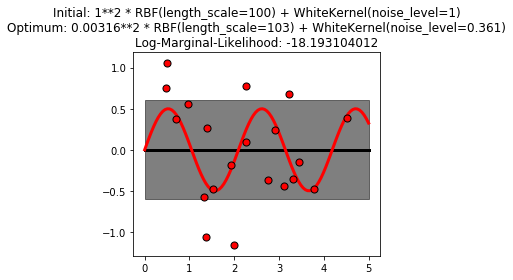

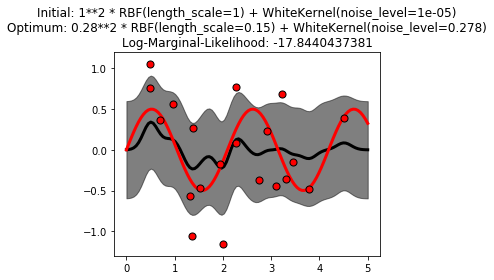

In [77]:
X = np.random.uniform(0, 5, 20)[:, np.newaxis]
y = 0.5 * np.sin(3 * X[:, 0]) + np.random.normal(0, 0.5, X.shape[0])

# First run
plt.figure(0)
kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)
X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

# Second run
plt.figure(1)
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)
X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
print(y_mean.shape,y_cov.shape)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

In [80]:
def plot(x,yt,yp,y_cov):
    fig = plt.figure()
    plt.plot(x, yt, label=u'Observations')
    plt.plot(x, yp, label=u'Prediction')
    plt.fill_between(x, yp - np.sqrt(np.diag(y_cov)),
                 yp + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
    plt.legend()

(24, 24) (24, 24)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.] (24, 24)


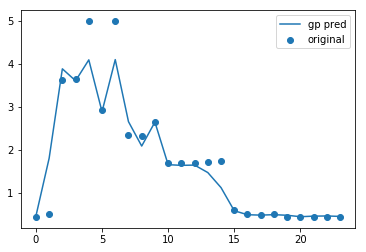

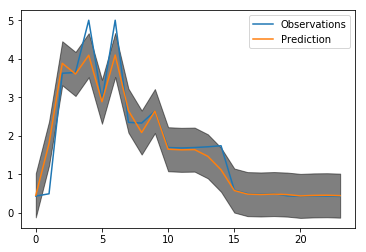

In [103]:
arr = np.array([robo.iloc[i,:-1] for i in range(24)])
ax = np.array([np.array(range(24)) for i in range(24)])
print(ay.shape, arr.shape)

ubs = []
for c in robo.columns[:-1]:
    ubs.append((max(robo[c])-min(robo[c]))*0.05)

stds_of_noise = abs(np.random.randn(len(ubs))*np.array(ubs))
# print(WhiteKernel(noise_level=stds_of_noise))#,noise_level_bounds=(np.zeros(len(ubs)),ubs)))
kernel = RBF(length_scale=24.0)+WhiteKernel(1e-5)
gpr = GaussianProcessRegressor(kernel=kernel,alpha=0.0)
pp,sts = gpr.predict(ax,return_cov=True)
gpr.fit(ax,arr)
pred,stds = gpr.predict(ax,return_cov=True)
print(pp,stds.shape)
plt.scatter(ax[0],arr[0],label='original')
plt.plot(ax[0],pred[0],label='gp pred')
plt.legend()

# plot(ax[0],arr[0],pp[0],sts)
plot(ax[0],arr[0],pred[0],stds)

In [63]:
# Add noise 
def get_gp(df,percentage_of_amplitude):
    ypreds = []
    for i,c in enumerate(df.columns[:-1]):
        upper_bound = max(df[c])-min(df[c])*percentage_of_amplitude
        std_of_noise = np.random.randn()*upper_bound
        kernel = WhiteKernel(noise_level=std_of_noise,noise_level_bounds=(0,upper_bound))
        gpr = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(np.array(list(range(24))).reshape(-1,1),df.iloc[i,:-1])
        ypreds.append(gpr.predict(np.array(list(range(24))).reshape(-1,1),return_std=True))
    return ypreds
         


    
yps = get_gp(robo,0.05)
plot(yps[0])

/Users/paulblankley/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:241: RuntimeWarning: invalid value encountered in log
  return np.log(np.hstack(theta))
/Users/paulblankley/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:288: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


ValueError: array must not contain infs or NaNs